## Amazon SageMaker DICOM Training Overview

In this example we will demonstrate how to integrate the [MONAI](http://monai.io) framework into Amazon SageMaker, and give example code of MONAI pre-processing transforms and neural network (DenseNet) that you can use to train a medical image classification model using DICOM images directly.  

Please also visit [Build a medical image analysis pipeline on Amazon SageMaker using the MONAI framework](https://aws.amazon.com/blogs/industries/build-a-medical-image-analysis-pipeline-on-amazon-sagemaker-using-the-monai-framework/) for additional details on how to deploy the MONAI model, pipe input data from S3, and perform batch inferences using SageMaker batch transform.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) github repositories.

Sample dataset is obtained from this [source COVID-CT-MD](https://github.com/ShahinSHH/COVID-CT-MD). The total dataset contains volumetric chest CT scans (DICOM files) of 169 patients positive for COVID-19 infection, 60 patients with CAP (Community Acquired Pneumonia), and 76 normal patients. For this demo purpose, only 26 images are randomly selected. The selection and preprocessing are not included in this demo. 

## Install necessary libries

In [ ]:
!pip install -r ./code/requirements.txt
!mkdir -p data

In [ ]:
!pip install --upgrade torch torchvision  ## upgrade torchvision to ensure consistent performance

In [3]:
import os
from pathlib import Path
from dotenv import load_dotenv
import sagemaker 

sess = sagemaker.Session()
env_path = Path('.') / 'set.env'
load_dotenv(dotenv_path=env_path)

bucket=sess.default_bucket() ## replace with <your bucket for the dataset>
bucket_path=os.environ.get('BUCKET_PATH')
user=os.environ.get('DICOM_USER')
password = os.environ.get('DICOM_PASSWORD')
datadir = 'data'
print('Bucket: '+bucket)

Bucket: sagemaker-us-east-1-741261399688


## Upload training dataset in S3

for this demo, we only use 25 images for model training
I have already downloaded the image, save in data folder 

+ *.dcm are the dicome images
+ manifest.json stores labels for each image

In [4]:
image_file_list=os.listdir(datadir)


image_file_list = [x  for x in image_file_list if x.endswith('dcm') ]

## Preprocess the dataset and display them

In [5]:
import monai
from monai.transforms import Compose, LoadImage, Resize, ScaleIntensity, ToTensor, SqueezeDim, RandRotate,RandFlip,RandZoom
import matplotlib.pyplot as plt
# define transform functions 
## preprocess the dataset before trainining using MONAI.  Based on img.shape, this is a channel last image
train_transforms = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    #RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    Resize(spatial_size=(512,-1)),
    ToTensor()
])
img = train_transforms(datadir+'/'+image_file_list[0])
img.shape ## check image size after preprocessing

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


torch.Size([512, 512, 1])

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


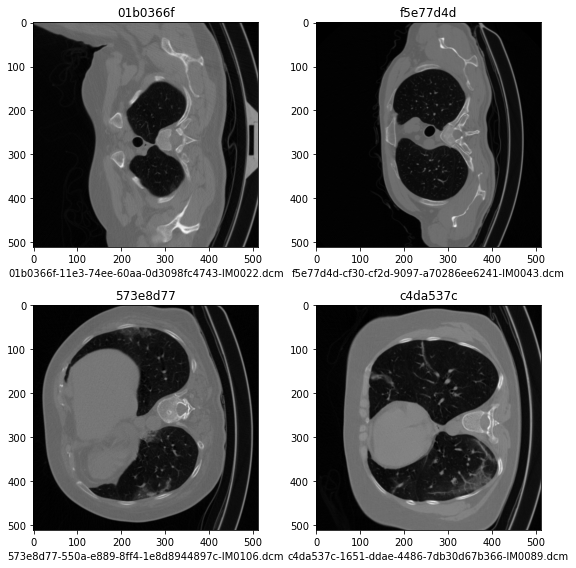

In [6]:
#Display sample of DICOM Images
inf_test = []
inf_test_label = []

trans = Compose([LoadImage(image_only=True), Resize(spatial_size=(512,-1))])
plt.subplots(2, 2, figsize=(8, 8))
for i in range(0,4):
    #s3.download_file(bucket, image_file_list[i], datadir+'/'+image_file_list[i])
    
    img = trans(datadir+'/'+image_file_list[i])
    print(img.shape)
    plt.subplot(2, 2, i + 1)
    plt.xlabel(image_file_list[i])
    plt.imshow(img, cmap='gray')
    plt.title(image_file_list[i].split('-')[0])
    inf_test.append(datadir+'/'+image_file_list[i])
    inf_test_label.append(image_file_list[i].split('-')[0])
    
plt.tight_layout()
plt.show()

In [7]:
datadir_test='test_data'

image_file_list=os.listdir(datadir_test)
image_file_list


['normal-IM0062.dcm', 'cap-IM0032.dcm', 'covid-IM0073.dcm', 'cap-IM0064.dcm']

## Data

### Create Sagemaker session and S3 location for DICOM dataset

In [8]:
import sagemaker
from sagemaker.s3 import S3Downloader, S3Uploader
import os

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
#inputs='s3://dataset-pathology/CovidTrainingV2'

sess =sess.default_bucket()

key='CovidTraining'
path=os.path.join("s3://",bucket,key)
#S3Uploader.upload('./data', path) 

## IF UPLOAD THE DATA TO S3, DO THE FOLLOWING STEP. we may skip the step if the the data has already been uploaded
inputs = S3Uploader.upload(local_path=datadir, desired_s3_uri=path) #(path=datadir, bucket=bucket,key_prefix=key)

print('input spec as an S3 path: {}'.format(inputs))

input spec as an S3 path: s3://sagemaker-us-east-1-741261399688/CovidTraining


In [9]:
inputs='s3://sagemaker-us-east-1-741261399688/CovidTraining'

## Train Model
### Training

The ```monai_dicom.py``` script provides all the code we need for training and hosting a SageMaker model (model_fn function to load a model). The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables, such as:

* SM_MODEL_DIR: A string representing the path to the directory to write model artifacts to. These artifacts are uploaded to S3 for model hosting.
* SM_NUM_GPUS: The number of gpus available in the current container.
* SM_CURRENT_HOST: The name of the current container on the container network.
* SM_HOSTS: JSON encoded list containing all the hosts .
Supposing one input channel, 'training', was used in the call to the PyTorch estimator's fit() method, the following will be set, following the format SM_CHANNEL_[channel_name]:

* SM_CHANNEL_TRAINING: A string representing the path to the directory containing data in the 'training' channel.
For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers).

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In [ ]:
!pygmentize code/train2.py

## Run training in SageMaker

The `PyTorch` class allows us to run our training function as a training job on SageMaker infrastructure.  We need to configure it with our training script, an IAM role, the number of training instances, the training instance type, and hyperparameters.  In this case we are going to run our training job on ```ml.m5.2xlarge``` instance.  But this example can be ran on one or multiple, cpu or gpu instances ([full list of available instances](https://aws.amazon.com/sagemaker/pricing/instance-types/)).  The hyperparameters parameter is a dict of values that will be passed to your training script -- you can see how to access these values in the ```monai_dicom.py``` script above.

In [40]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='train.py',
                    source_dir='code',
                    role=role,
                    framework_version='1.5.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.m5.2xlarge',
                    hyperparameters={
                        'backend': 'gloo',
                        'epochs': 100,
                         'seed':123
                    })

After we've constructed our PyTorch object, we can fit it using the DICOM dataset we uploaded to S3.

In [ ]:
%%time
estimator.fit({'train': inputs})

In [39]:
##download the model and check its content

## Deploy the endpoint with the following options

+ default inference with `numpy` as input

+ customized inference with `JSON` file pointing to the image file in S3 [./source/inference.py]

for further information, you may refer to [pytoch-inference-hander](https://github.com/aws/sagemaker-pytorch-inference-toolkit/blob/master/src/sagemaker_pytorch_serving_container/default_pytorch_inference_handler.py) 

### Option 1: synchronous inference directly with estimator

In [42]:

predictor = estimator.deploy(initial_instance_count=1,entry_point='inference.py', instance_type='ml.m5.xlarge',serializer=sagemaker.serializers.JSONSerializer(),deserializer=sagemaker.deserializers.JSONDeserializer())

-------!

In [43]:
%%time
payload={"bucket": bucket,
    "key":"test_data/normal-IM0062.dcm"}

predictor.predict(payload)

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 2.91 s


{'results': {'class': 'Normal', 'probability': 0.57}}

### Option 2: Deploy through model data in S3

In [47]:
model_data=estimator.__dict__['output_path']+estimator.__dict__['_current_job_name']+'/output/model.tar.gz'

In [48]:
model_data

's3://sagemaker-us-east-1-741261399688/pytorch-training-2022-05-25-03-03-05-341/output/model.tar.gz'

In [49]:
## Option 1: BYOS
from sagemaker.pytorch.model import PyTorchModel


model = PyTorchModel(
    entry_point="inference.py", ## inference code with customerization
    #source_dir="code",        ## folder with the inference code
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)
predictor2 = model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge',entry_point='inference.py',source_dir='code',
                            serializer=sagemaker.serializers.JSONSerializer(),deserializer=sagemaker.deserializers.JSONDeserializer())

-------!

In [ ]:
%%time
payload={"bucket": bucket,
    "key":"test_data/normal-IM0062.dcm"}

predictor2.predict(payload)